In [258]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.sparse import vstack
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import os

In [259]:
articles = pd.read_csv("shared_articles.csv", delimiter= ',')
interactions = pd.read_csv("users_interactions.csv", delimiter= ',')

In [260]:
#1
#Pre-processing, labeling event ratings

#function that creates eventRatings
def rank_events(data, exists=True):
    if exists:
        data = pd.read_csv ('df.csv', delimiter= ',')
        return(data)
    else: 
        data['eventRating'] = ''

        for session in data['sessionId']:
            df1= data[data['sessionId']==session]
            for content in df1['contentId']:
                df = df1[df1['contentId']==content]
                if df.empty:
                    continue
                idx = df.index.values.tolist()
                if (df['eventType'].str.contains("LIKE")).any():
                    data.loc[idx, 'eventRating'] = 5.0
                elif ((df['eventType'].str.contains("FOLLOW")).any() & (df['eventType'].str.contains("BOOKMARK")).any()):
                    data.loc[idx, 'eventRating'] = 4.0
                elif ((df['eventType'].str.contains("FOLLOW")).any() | (df['eventType'].str.contains("BOOKMARK")).any() & ~((df['eventType'].str.contains("FOLLOW")).any() & (df['eventType'].str.contains("BOOKMARK")).any())):
                    data.loc[idx, 'eventRating'] = 3.0
                elif ((df['eventType'].str.contains("COMMENT CREATED")).any() & ~((df['eventType'].str.contains("BOOKMARK")).any() | (df['eventType'].str.contains("FOLLOW")).any() | (df['eventType'].str.contains("LIKE")).any())):
                    data.loc[idx, 'eventRating'] = 2.0
                elif ((df['eventType'].str.contains("VIEW")).any() & ~((df['eventType'].str.contains("COMMENT CREATED")).any() | (df['eventType'].str.contains("BOOKMARK")).any() | (df['eventType'].str.contains("FOLLOW")).any() | (df['eventType'].str.contains("LIKE")).any())):
                    data.loc[idx,'eventRating'] = 1.0
        data.to_csv('df.csv')            
        return(data)                       

#set to False if eventRatings has not been created yet
interactions = rank_events(interactions, os.path.isfile("df.csv"))
#interactions["eventRating"].head(10)

In [261]:
#1

#function that filters dataset according to wanted number of user and article interactions and computes popularity ranking of given set 
def filter_df(data, articles, user_interactions_at_least, article_interactions_at_least, pivot=True):

    #Selecting articles and users with enough interactions
    users_interactions_count = data.groupby(['personId', 'contentId']).size().groupby('personId').size()
    print('number of users:', len(users_interactions_count))
    users_with_enough_interactions_df = users_interactions_count[users_interactions_count >= user_interactions_at_least].reset_index()[['personId']]

    article_interactions_count = data.groupby(['personId', 'contentId']).size().groupby('contentId').size()
    articles_with_enough_interactions_df = article_interactions_count[article_interactions_count >= article_interactions_at_least].reset_index()[['contentId']]

    print("articles with at least", article_interactions_at_least, "interactions:", len(articles_with_enough_interactions_df))
    print("users with at least", user_interactions_at_least, "interactions:", len(users_with_enough_interactions_df))
    print('number of interactions:', len(data))
    interactions_from_selected_users_df = data.merge(users_with_enough_interactions_df, 
                how = 'right',
                left_on = 'personId',
                right_on = 'personId')
    print('number of interactions from users with at least 3 interactions:', len(interactions_from_selected_users_df))


    interactions_from_selected_users_df = interactions_from_selected_users_df.merge(articles_with_enough_interactions_df, 
                how = 'right',
                left_on = 'contentId',
                right_on = 'contentId')
    print("number of interactions users with at least 3 interactions and with articles of at least 2 interactions", len(interactions_from_selected_users_df))

    articles_fil = articles[articles['contentId'].isin(articles_with_enough_interactions_df['contentId'])]
    print("num articles:", len(articles_fil))

    #select unique item/user interactions
    if  pivot==False: 
        interactions_filtered = interactions_from_selected_users_df[['personId', 'contentId','eventRating']].drop_duplicates()
    else:
        interactions_df =interactions_from_selected_users_df[['personId', 'contentId','eventRating']]
        interactions_filtered = interactions_from_selected_users_df[['personId', 'contentId','eventRating']]
        interactions_filtered = interactions_filtered.pivot_table(index='personId', columns='contentId', values='eventRating', fill_value=0)
    

    print('number of of unique user/item interactions:', len(interactions_filtered))

    return(interactions_filtered, interactions_df, articles_fil)

interactions_selected, interactions_df, articles = filter_df(data=interactions, articles=articles, user_interactions_at_least=3, article_interactions_at_least=2, pivot=True)  
#interactions_selected.head(30)  

number of users: 1895
articles with at least 2 interactions: 2744
users with at least 3 interactions: 1400
number of interactions: 72312
number of interactions from users with at least 3 interactions: 71244
number of interactions users with at least 3 interactions and with articles of at least 2 interactions 70849
num articles: 2760
number of of unique user/item interactions: 1400


In [262]:
user_ids = list(interactions_selected.index)
content_ids = list(interactions_selected.T.index)

#indexing by personId
pre_processed_data_index = interactions_df.set_index('personId')
#pre_processed_data_index = interactions_selected

#train-test split
train_set, test_set = train_test_split(interactions_df,  stratify=interactions_df['personId'], train_size=0.80)
train_set_index = train_set.set_index('personId')
test_set_index = test_set.set_index('personId')


In [263]:
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

#Inspired by https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/

class CFrecommender:
    MODEL_NAME = 'Collaborative Filtering'

    def __init__(self, items=None, item_based=True):
        
        #user all data
        #self.matrix = csr_matrix(interactions_selected)

        #use train data
        self.matrix = csr_matrix(train_set_index.pivot_table(index='personId', columns='contentId', values='eventRating', fill_value=0)) 
        #self.matrix = csr_matrix(test_set_index.pivot_table(index='personId', columns='contentId', values='eventRating', fill_value=0))

        self.users = dict(zip(user_ids, list(range(len(user_ids)))))
        self.contents = dict(zip(content_ids, list(range(len(content_ids)))))
        self.users_inv = dict(zip(list(range(len(user_ids))), user_ids))
        self.contents_inv = dict(zip(list(range(len(content_ids))), content_ids))

        self.item_based = item_based
        self.items = items


    def get_model_name(self):
        return self.MODEL_NAME
    

    def users_highest_item(self, user_id, item_based, items_to_ignore=[]):
        user_list = interactions_df[interactions_df['personId'] == user_id]
        highest_rated_items = user_list[user_list['eventRating'] == max(user_list['eventRating'])]['contentId']
        if item_based:
            highest_rated_item = highest_rated_items.iloc[0]
        elif not item_based:
            highest_rated_item = [item for idx, item in enumerate(highest_rated_items) if item not in items_to_ignore]
            if len(highest_rated_item)==0:
                highest_rated_item = []
            else: 
                highest_rated_item = highest_rated_item[0]
        #print(highest_rated_item) 
        return(highest_rated_item)

    def find_similar(self, matrix, item_based):
        if item_based:
            # For item-based collaborative filtering, transpose the matrix
            matrix = matrix.T

        # Calculate cosine similarity
        similarity_matrix = cosine_similarity(matrix, dense_output=False)
        return similarity_matrix

    def recommend_items(self, user_id, items_to_ignore=[], topn=1000, item_based=True, verbose=False):
        item_based=self.item_based
        similarity_matrix = self.find_similar(self.matrix, item_based)

        #if not item_based:
        #    print("no")

        if item_based:
            
        # Get the index of the user in the matrix
            user_index = self.users.get(user_id)

            similar_item_to = self.users_highest_item(user_id, item_based)

            # Compute the scores based on cosine similarity
            scores = similarity_matrix[self.contents.get(similar_item_to)]
            scores = pd.DataFrame(scores.todense())

            # Filter out items already interacted by the user
            #scores = np.array([score if idx not in items_to_ignore else -1 for idx, score in enumerate(scores)])
            scores = np.array([score if self.contents_inv.get(idx) not in items_to_ignore else -1 for idx, score in enumerate(scores)])

            recommended_item_indices = np.argsort(scores, kind='heapsort')[::-1][:topn]

        #    Get contentIds and scores for top items
            recommended_items = [self.contents_inv.get(idx) for idx in recommended_item_indices]
            scores = [scores[idx] for idx in recommended_item_indices]

        elif not item_based:
            user_index = self.users.get(user_id)
            scores = similarity_matrix[user_index]
            scores = pd.DataFrame(scores.todense())
            #recommended_items = [self.users_highest_item(user) for user in recommended_users]
            # Get indices of top items
            recommended_item_indices = np.argsort(scores, kind='heapsort')[::-1][:topn]

            # Get contentIds and scores for top items
            recommended_items = [self.users_highest_item(self.users_inv.get(idx), item_based, items_to_ignore) for idx in recommended_item_indices]
            scores = [scores[idx] for idx in recommended_item_indices]

        recommendations_df = pd.DataFrame({
            'contentId': recommended_items,
            'itemScore': scores
        })

        if recommendations_df.empty:
            print("Empty", user_id, item_based, len(items_to_ignore))

        if verbose:
            if self.items is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventRating', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df


user_recommender_model2 = CFrecommender(items=articles, item_based=False)
item_recommender_model2 = CFrecommender(items=articles, item_based=True)
item_recommender_model2.recommend_items(-9016528795238256703)

,contentId,itemScore
0,9191014301634017491,2734
1,9175693555063886126,2733
2,9168028029170358424,2732
3,9158289456544908688,2731
4,9151634133568930081,2730
...,...,...
995,2589533162305407436,1739
996,2586379029487881843,1738
997,2581138407738454418,1737
998,2573252627510191315,1736


In [284]:
#Recall@N implementation is based on Kaggle Recommendation systems 101

class Recall_n:

    def get_items_interacted(self, person_id, interactions_dat):
        # Get the user's data and merge in the movie information.
        interacted_items = interactions_dat.loc[person_id]['contentId']
        return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

    def get_not_interacted_items_sample(self, person_id, sample_size, seed=12):
        interacted_items = self.get_items_interacted(person_id, pre_processed_data_index)
        all_items = set(articles['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(list(non_interacted_items), sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = test_set_index.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        #print(person_id)
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=self.get_items_interacted(person_id, train_set_index), topn=1000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        hits_at_30_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=100, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #print(len(valid_recs))
            #print(valid_recs)
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10
            hit_at_30, index_at_30 = self._verify_hit_top_n(item_id, valid_recs, 30)
            hits_at_30_count += hit_at_30

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)
        recall_at_30 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10,
                          'recall@30': recall_at_30}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(test_set_index.index.unique().values)):
            #print(len(list(test_set_index.index.unique().values)), len(user_ids))
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
recall_n_evaluator = Recall_n() 

In [266]:
#NDCG based on https://www.kaggle.com/code/wendykan/ndcg-example

class NDCG:

    def dcg_at_k(self, r, k, method=0):
       
        r = np.asfarray(r)[:k]
        if r.size:
            if method == 0:
                return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
            elif method == 1:
                return np.sum(r / np.log2(np.arange(2, r.size + 2)))
            else:
                raise ValueError('method must be 0 or 1.')
        return 0.


    def ndcg_at_k(self, r, k, method=1):
       
        dcg_max = self.dcg_at_k(sorted(r, reverse=True), k, method)
        if not dcg_max:
            return 0.
        return self.dcg_at_k(r, k, method) / dcg_max
    
    def get_items_interacted(self, person_id, interactions_dat):
        # Get the user's data and merge in the movie information.
        interacted_items = interactions_dat.loc[person_id]['contentId']
        return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

    def evaluate_model_for_user(self, model, person_id, k):
        #Getting the items in test set
        interacted_values_testset = test_set_index.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user

        personal_recommendations = model.recommend_items(person_id, items_to_ignore=self.get_items_interacted(person_id, train_set_index), topn=1000)
        valid_recs_df = personal_recommendations[personal_recommendations['contentId'].isin(person_interacted_items_testset)] 

        if type(interacted_values_testset) == pd.Series:
            ndcg = 0

        else:    
            valid_recs_df = interacted_values_testset.merge(valid_recs_df, 
                    how = 'right',
                    left_on = 'contentId',
                    right_on = 'contentId')

            valid_recs = valid_recs_df['eventRating'].values
            if len(valid_recs) < k:
                k = len(valid_recs)
            ndcg = self.ndcg_at_k(valid_recs, k)
        
        # Use sim_cos scores in NDCG
        #valid_recs = personal_recommendations['itemScore']
        #ndcg = self.ndcg_at_k(valid_recs, k)

        person_metrics = {'ndcg':ndcg,
                          'interacted_count': interacted_items_count_testset}
        return person_metrics

    def evaluate_model(self, model, k):
            #print('Running evaluation for users')
            people_metrics = []
            for idx, person_id in enumerate(list(test_set_index.index.unique().values)):
                person_metrics = self.evaluate_model_for_user(model, person_id, k)  
                person_metrics['_person_id'] = person_id
                people_metrics.append(person_metrics)
            print('%d users processed' % idx)

            detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
            ndcg = detailed_results_df['ndcg'].sum() / len(detailed_results_df)
            global_metrics = {'modelName': model.get_model_name(),
                            'ndcg': ndcg}    
            return global_metrics, detailed_results_df    

recall_ndcg_evaluator = NDCG() 


#r = [2, 1, 2, 0]
#recall_ndcg_evaluator.ndcg_at_k(r, 4, method=1)

In [267]:
#Evaluating Item-based model

print('Item-based recommendation model: Recall_N:')
pop_global_metrics_item_recall, pop_detailed_results_df_item_recall = recall_n_evaluator.evaluate_model(item_recommender_model2)
print('\nGlobal metrics:\n%s' % pop_global_metrics_item_recall)
pop_detailed_results_df_item_recall.head(10)

print('Item-based recommendation model: NDCG:')
pop_global_metrics_item_ndcg, pop_detailed_results_df_item_ndcg = recall_ndcg_evaluator.evaluate_model(item_recommender_model2, k=101)
print('\nGlobal metrics:\n%s' % pop_global_metrics_item_ndcg)
pop_detailed_results_df_item_ndcg.head(10)

Item-based recommendation model: Recall_N:
1355 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.019823421622522073, 'recall@10': 0.0407296351824088}
Item-based recommendation model: NDCG:
1355 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'ndcg': 0.46932846236821607}


,ndcg,interacted_count,_person_id
49,0.664375,270,-1032019229384696495
94,1.000000,256,3609194402293569455
32,0.894644,225,-1443636648652872475
83,0.920624,193,-2626634673110551643
118,1.000000,132,-3596626804281480007
127,0.674273,120,-2979881261169775358
78,1.000000,116,3636910968448833585
79,0.758646,115,2416280733544962613
14,1.000000,113,3302556033962996625
102,0.796868,109,-709287718034731589


In [268]:
print('User-based recommendation model: Recall_N:')
pop_global_metrics_user_recall, pop_detailed_results_df_user_recall = recall_n_evaluator.evaluate_model(user_recommender_model2)
print('\nGlobal metrics:\n%s' % pop_global_metrics_user_recall)
pop_detailed_results_df_user_recall.head(10)

print('User-based recommendation model: NDCG:')
pop_global_metrics_user_ndcg, pop_detailed_results_df_user_ndcg = recall_ndcg_evaluator.evaluate_model(user_recommender_model2, k=101)
print('\nGlobal metrics:\n%s' % pop_global_metrics_user_ndcg)
pop_detailed_results_df_user_ndcg.head(10)

User-based recommendation model: Recall_N:
1355 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.048559053806430115, 'recall@10': 0.07612860236548392}
User-based recommendation model: NDCG:
1355 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'ndcg': 0.5960142051274611}


,ndcg,interacted_count,_person_id
49,0.947852,270,-1032019229384696495
94,1.000000,256,3609194402293569455
32,0.728997,225,-1443636648652872475
83,1.000000,193,-2626634673110551643
118,0.727993,132,-3596626804281480007
127,0.720956,120,-2979881261169775358
78,1.000000,116,3636910968448833585
79,0.698666,115,2416280733544962613
14,0.718777,113,3302556033962996625
102,0.843277,109,-709287718034731589


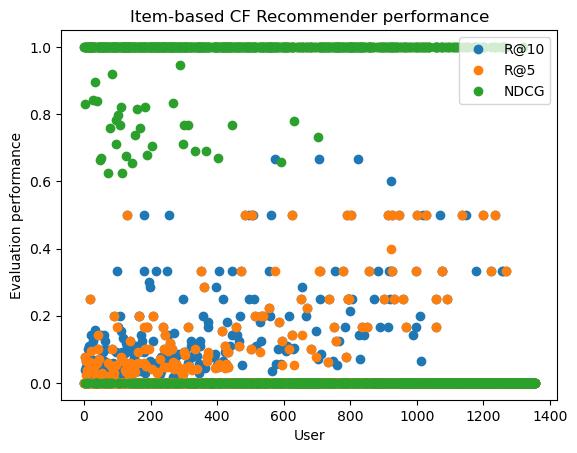

In [292]:
import matplotlib.pyplot as plt

plt.plot(pop_detailed_results_df_item_recall["recall@10"], "o")
plt.plot(pop_detailed_results_df_item_recall["recall@5"], "o")
plt.plot(pop_detailed_results_df_item_ndcg["ndcg"], "o")
plt.xlabel("User")
plt.legend(["R@10", "R@5", "NDCG"], loc="upper right")
plt.ylabel("Evaluation performance")
plt.title("Item-based CF Recommender performance")
plt.show()

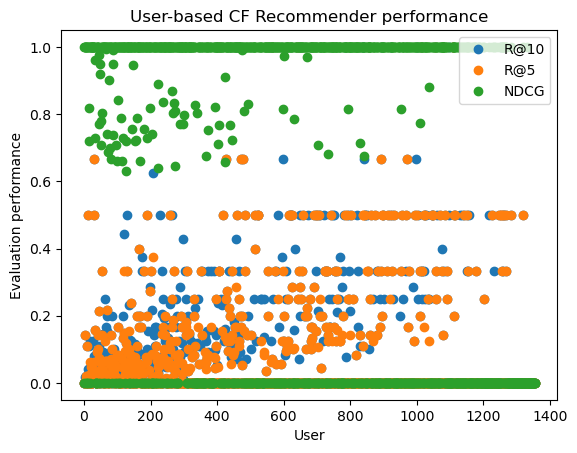

In [277]:
plt.plot(pop_detailed_results_df_user_recall["recall@10"], "o")
plt.plot(pop_detailed_results_df_user_recall["recall@5"], "o")
plt.plot(pop_detailed_results_df_user_ndcg["ndcg"], "o")
plt.xlabel("User")
plt.legend(["R@10", "R@5", "NDCG"], loc="upper right")
plt.ylabel("Evaluation performance")
plt.title("User-based CF Recommender performance")
plt.show()

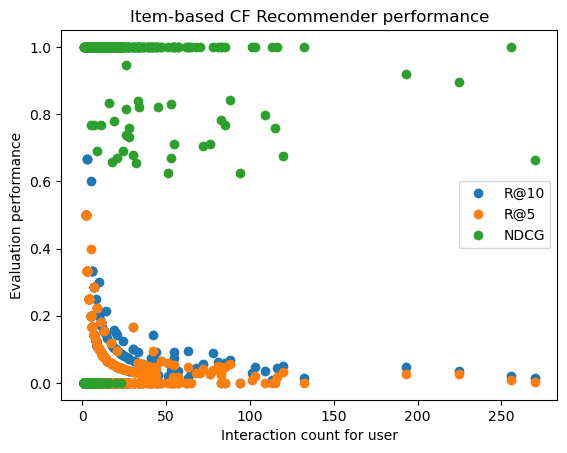

In [279]:
plt.plot(pop_detailed_results_df_item_recall["interacted_count"], pop_detailed_results_df_item_recall["recall@10"], "o")
plt.plot(pop_detailed_results_df_item_recall["interacted_count"], pop_detailed_results_df_item_recall["recall@5"], "o")
plt.plot(pop_detailed_results_df_item_ndcg["interacted_count"] , pop_detailed_results_df_item_ndcg["ndcg"], "o")
plt.xlabel("Interaction count for user")
plt.legend(["R@10", "R@5", "NDCG"], loc="center right")
plt.ylabel("Evaluation performance")
plt.title("Item-based CF Recommender performance")
plt.show()

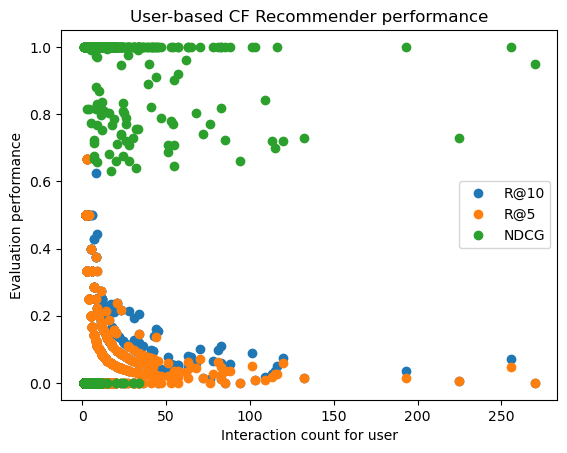

In [280]:
plt.plot(pop_detailed_results_df_user_recall["interacted_count"], pop_detailed_results_df_user_recall["recall@10"], "o")
plt.plot(pop_detailed_results_df_user_recall["interacted_count"], pop_detailed_results_df_user_recall["recall@5"], "o")
plt.plot(pop_detailed_results_df_user_ndcg["interacted_count"], pop_detailed_results_df_user_ndcg["ndcg"], "o")
plt.xlabel("Interaction count for user")
plt.legend(["R@10", "R@5", "NDCG"], loc="center right")
plt.ylabel("Evaluation performance")
plt.title("User-based CF Recommender performance")
plt.show()